# Final Evaluation/Submission - House Pricing

This notebook:
 - trains the best model(ridge) on the full training data
 - makes predictions on the test set
 - reverses log transformation
 - saves prediction for kaggle

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge

# Load processed training data
train_df = pd.read_csv('../data/processed_train.csv')

# Load original test data
test_raw = pd.read_csv('../data/test.csv')


## Preprocess Test Data

In [2]:
# Load raw test set
test_raw = pd.read_csv('../data/test.csv')

# Drop the same columns as in training (those with >20% missing)
cols_to_drop = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu']
test_raw = test_raw.drop(columns=cols_to_drop)

# Fill missing values: categorical with 'None'
cat_cols = test_raw.select_dtypes(include='object').columns
test_raw[cat_cols] = test_raw[cat_cols].fillna('None')

# Fill numeric with median
num_cols = test_raw.select_dtypes(include=np.number).columns
test_raw[num_cols] = test_raw[num_cols].fillna(test_raw[num_cols].median())

# Log1p transform the same skewed numeric features
# (retrieved from the training data's skewed features)
skewed_features = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]
for feature in skewed_features:
    if feature in test_raw.columns:
        test_raw[feature] = np.log1p(test_raw[feature])

# One-hot encode
test_encoded = pd.get_dummies(test_raw, drop_first=True)

# Align test with training columns
X_train = pd.read_csv('../data/processed_train.csv').drop('SalePrice', axis=1)
X_test = test_encoded.reindex(columns=X_train.columns, fill_value=0)


# Train Final Ridge Model on full training data

In [3]:
from sklearn.linear_model import Ridge
import numpy as np

# Load training data
train_df = pd.read_csv('../data/processed_train.csv')
X_train = train_df.drop('SalePrice', axis=1)
y_train = train_df['SalePrice']

# best alpha from Ridge tuning
final_ridge = Ridge(alpha=10)
final_ridge.fit(X_train, y_train)

# Predict on test data
preds_log = final_ridge.predict(X_test)

# Reverse the log1p transform
preds = np.expm1(preds_log)



# Final Submission Format

✅ Submission file saved to data/kaggle_submission.csv
X_train shape: (1458, 229)
X_test shape: (1459, 229)
Columns only in train: set()
Columns only in test: set()


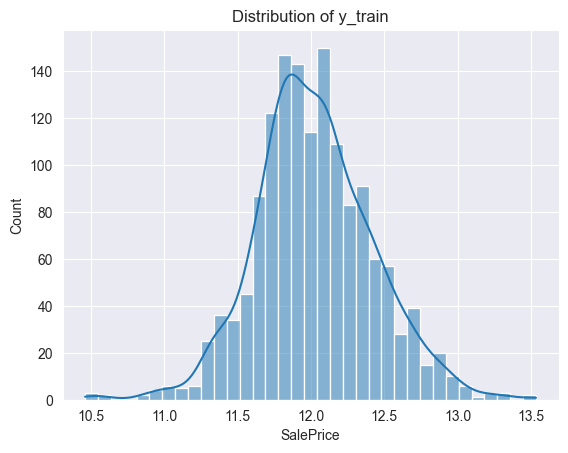

Sample y_train values:
0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64


In [4]:
# Load test IDs
test_ids = pd.read_csv('../data/test.csv')['Id']

# Create submission DataFrame
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': preds
})

# Save to CSV
submission.to_csv('../data/kaggle_submission.csv', index=False)
print("✅ Submission file saved to data/kaggle_submission.csv")

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Check column mismatches
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)

print("Columns only in train:", train_cols - test_cols)
print("Columns only in test:", test_cols - train_cols)

import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(y_train, kde=True)
plt.title("Distribution of y_train")
plt.show()

print("Sample y_train values:")
print(y_train.head())
